In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# load cleaned data
df = pd.read_csv("data/HR_data_cleaned.csv")

In [163]:
df.columns

Index(['HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Max',
       'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew', 'HR_TD_Slope_min',
       'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope', 'TEMP_TD_Mean',
       'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min', 'TEMP_TD_Max',
       'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew', 'TEMP_TD_Slope_min',
       'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean', 'TEMP_TD_Slope',
       'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std', 'EDA_TD_P_Min',
       'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis', 'EDA_TD_P_Skew',
       'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max', 'EDA_TD_P_Slope_mean',
       'EDA_TD_P_Slope', 'EDA_TD_T_Mean', 'EDA_TD_T_Median', 'EDA_TD_T_std',
       'EDA_TD_T_Min', 'EDA_TD_T_Max', 'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis',
       'EDA_TD_T_Skew', 'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max',
       'EDA_TD_T_Slope_mean', 'EDA_TD_T_Slope', 'EDA_TD_P_Peaks',
       'EDA_TD_P_RT', 'EDA_TD_P_ReT', 'Individu

### Feature selection

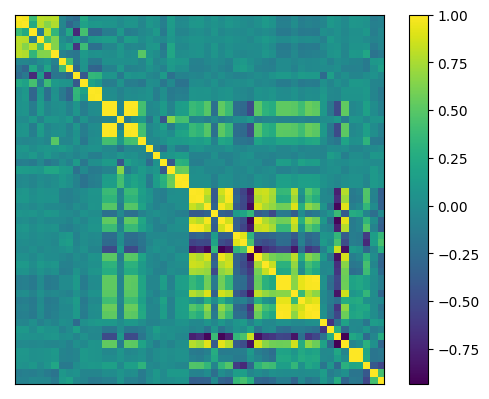

In [167]:
# feature selection by correlation between columns

def select_cols_to_drop(df, corr_cutoff):
    # continuous columns
    continuous_cols = df.columns[0:51]

    # absolute value of correlation matrix
    corr_matrix = df[continuous_cols].corr().abs()

    # upper triangular array of True booleans
    bool_array = np.ones(corr_matrix.shape).astype(bool)
    T = np.triu(bool_array, 1)

    T_corr_matrix = corr_matrix.where(T)

    # array of columns to drop
    drop_cols = []

    # drop columns that have at least corr_cutoff absolute correlation with at least one other column
    for col in T_corr_matrix.columns:
        if any(T_corr_matrix[col] > corr_cutoff):
            drop_cols.append(col)
    
    return drop_cols

# plot absolute value correlation matrix (without taking absolute value first)
continuous_cols = df.columns[0:51]
plt.imshow(df[continuous_cols].corr())
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

### Clustering

In [168]:
# select features to use for clustering

drop_cols = select_cols_to_drop(df, corr_cutoff=0.8)
print(f"Number of columns to drop: {len(drop_cols)}")

cluster_cols = df[continuous_cols].drop(columns=drop_cols).columns
print(f"Number of columns to use for clustering: {len(cluster_cols)}")
print(f"Columns: {cluster_cols}")

Number of columns to drop: 25
Number of columns to use for clustering: 26
Columns: Index(['HR_TD_Mean', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Kurtosis', 'HR_TD_Skew',
       'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean',
       'TEMP_TD_Mean', 'TEMP_TD_std', 'TEMP_TD_AUC', 'TEMP_TD_Kurtosis',
       'TEMP_TD_Skew', 'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max',
       'TEMP_TD_Slope_mean', 'EDA_TD_P_Mean', 'EDA_TD_P_Min',
       'EDA_TD_P_Kurtosis', 'EDA_TD_T_Mean', 'EDA_TD_T_Kurtosis',
       'EDA_TD_T_Skew', 'EDA_TD_T_Slope_mean', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT',
       'EDA_TD_P_ReT'],
      dtype='object')


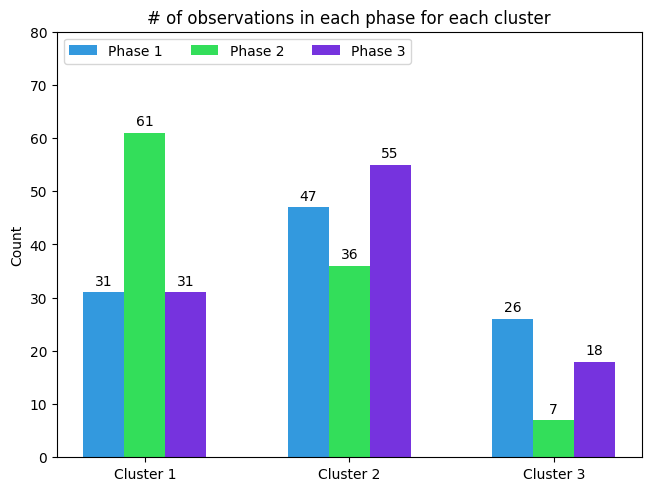

In [166]:
# k means clustering
kmeans = KMeans(n_clusters=3, random_state=1).fit(df[cluster_cols])
labels = kmeans.labels_


# plot phase count for each cluster
phases = ["Phase_0", "Phase_1", "Phase_2"]
counts = []
for i in range(len(phases)):
    phase_idx = df.index[df[phases[i]] == True].to_numpy()

    _, count = np.unique(labels[phase_idx], return_counts=True)
    
    if len(count) < 3:
        count = np.insert(count, 0, 0)
    
    counts.append(count)


clusters = ("Cluster 1", "Cluster 2", "Cluster 3")
data = {
    "Phase 1": tuple(counts[0]),
    "Phase 2": tuple(counts[1]),
    "Phase 3": tuple(counts[2])
}

tick_space = np.arange(len(clusters))
width = 0.2
mult = 0
colors = ["#3399de", "#33de5a", "#7633de"]

fig, ax = plt.subplots(layout='constrained')

for i, (phase, count) in enumerate(data.items()):
    bar_offset = width * mult
    rects = ax.bar(tick_space + bar_offset, count, width, label=phase, color=colors[i])
    ax.bar_label(rects, padding=3)
    mult += 1

ax.set_xticks(tick_space + width, clusters)
ax.set_ylim(0, 80)
ax.legend(loc="upper left", ncols=3)
ax.set_ylabel("Count")
ax.set_title("# of observations in each phase for each cluster")

plt.show()


### Scatter matrix plot of the least correlated features

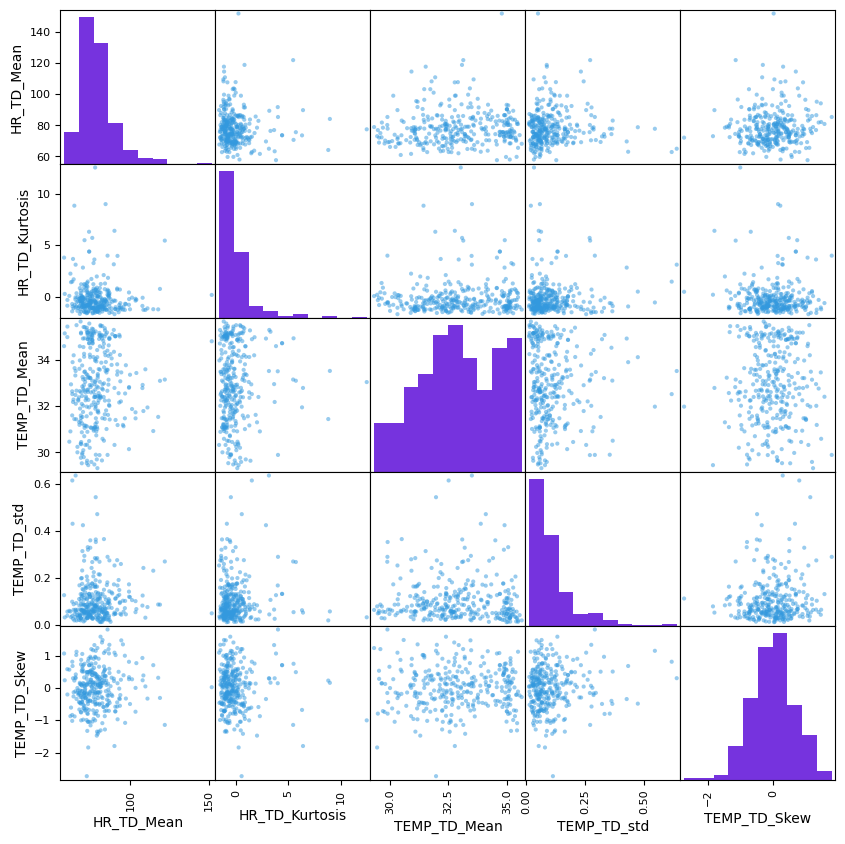

In [170]:
from pandas.plotting import scatter_matrix

# use non standardized data for histograms
df_no_s = pd.read_csv("data/HR_data.csv")

# select features to plot (corr_cutoff=0.15 drops 46 features such that we have 5 left)
drop_cols = select_cols_to_drop(df, corr_cutoff=0.15)

cols = df_no_s[continuous_cols].drop(columns=drop_cols).columns
df2 = df_no_s[cols]

# scatter/histogram matrix plot of the 5 features with least correlation with all other features
scatter_mat = scatter_matrix(df2, figsize=(10,10), hist_kwds={"color": "#7633de"}, color="#3399de")